# Group 11: Modeling Suspension and Expulsion Rates Based on Various School Demographic Information

We will attempt to predict whether a school has a high discipline rate (high suspension and expulsion rate) based on various factors including ethnicity, socioeconomic static, and absence rates

In [1]:
!pip3 install folium --upgrade
!pip3 install matplotlib
!pip3 install pandas
!pip3 install contextily
!pip3 install geopandas
!pip3 install chardet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
#from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import json
import os
from branca.colormap import linear
import branca.colormap
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

# Import any data cleaning libraries here

# Import your selected models here

# Import any other libraries here
from sklearn.model_selection import GridSearchCV

We obtain our datasets from https://www.cde.ca.gov/

In [3]:
# Import relevnt datasets
expulsion_data_url = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion22-v3.txt'
absence_data_url = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism22-v2.txt'
suspension_data_url = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension22-v2.txt'

expulsion_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion19.txt'
absence_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism19.txt'
suspension_data_url_2019 = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension19.txt'

# expulsion_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/discipline/expulsion18.txt'
absence_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/attendance/chronicabsenteeism18.txt'
# suspension_data_url_2018 = 'https://www3.cde.ca.gov/demo-downloads/discipline/suspension18.txt'

# Expulsion
response_expulsion = requests.get(expulsion_data_url)
response_expulsion.raise_for_status()

response_expulsion_2019 = requests.get(expulsion_data_url_2019)
response_expulsion_2019.raise_for_status()

# response_expulsion_2018 = requests.get(expulsion_data_url_2018)
# response_expulsion_2018.raise_for_status()

# Absence
response_absence = requests.get(absence_data_url)
response_absence.raise_for_status()

response_absence_2019 = requests.get(absence_data_url_2019)
response_absence_2019.raise_for_status()

response_absence_2018 = requests.get(absence_data_url_2018)
response_absence_2018.raise_for_status()

# Suspension
response_suspension = requests.get(suspension_data_url)
response_suspension.raise_for_status()

response_suspension_2019 = requests.get(suspension_data_url_2019)
response_suspension_2019.raise_for_status()

# response_suspension_2018 = requests.get(suspension_data_url_2018)
# response_suspension_2018.raise_for_status()

expulsion_data_2022 = pd.read_csv(StringIO(response_expulsion.text), sep='\t')
suspension_data_2022 = pd.read_csv(StringIO(response_suspension.text), sep='\t')
absence_data_2022 = pd.read_csv(StringIO(response_absence.text), sep='\t')
new_column_names = {col: col.replace(' ', '') for col in absence_data_2022.columns}
absence_data_2022 = absence_data_2022.rename(columns=new_column_names)
acgr_data_2022 = pd.read_csv('data/acgr22.csv')

expulsion_data_2019 = pd.read_csv(StringIO(response_expulsion_2019.text), sep='\t')
expulsion_data_2019 = expulsion_data_2019.rename(columns={'Cumulative Enrollment': 'CumulativeEnrollment'}, inplace=False)
suspension_data_2019 = pd.read_csv(StringIO(response_suspension_2019.text), sep='\t')
absence_data_2019 = pd.read_csv(StringIO(response_absence_2019.text), sep='\t')
acgr_data_2019 = pd.read_csv('data/acgr19.csv')

expulsion_data_2018 = pd.read_csv('data/expulsion18.csv')
suspension_data_2018 = pd.read_csv('data/suspension18.csv')
absence_data_2018 = pd.read_csv(StringIO(response_absence_2018.text), sep='\t')
acgr_data_2018 = pd.read_csv('data/acgr18.csv')

expulsion_data = pd.concat([expulsion_data_2022, expulsion_data_2019, expulsion_data_2018], ignore_index=True)
suspension_data = pd.concat([suspension_data_2022, suspension_data_2019, suspension_data_2018], ignore_index=True)
absence_data = pd.concat([absence_data_2022, absence_data_2019, absence_data_2018], ignore_index=True)
acgr_data = pd.concat([acgr_data_2022, acgr_data_2019, acgr_data_2018], ignore_index=True)

In [4]:
acgr_data[acgr_data['AggregateLevel']=='S']

,AcademicYear,AggregateLevel,CountyCode,DistrictCode,SchoolCode,CountyName,DistrictName,SchoolName,CharterSchool,DASS,...,SPED Certificate (Count),SPED Certificate (Rate),GED Completer (Count),GED Completer (Rate),Other Transfer (Count),Other Transfer (Rate),Dropout (Count),Dropout (Rate),Still Enrolled (Count),Still Enrolled (Rate)
66084,2021-22,S,1,10017.0,112607.0,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,All,All,...,0,0.0,0,0.0,0,0.0,1,2.3,0,0.0
66085,2021-22,S,1,10017.0,112607.0,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,All,All,...,0,0.0,0,0.0,0,0.0,4,10.3,1,2.6
66086,2021-22,S,1,10017.0,112607.0,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,All,All,...,*,*,*,*,*,*,*,*,*,*
66087,2021-22,S,1,10017.0,112607.0,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,All,All,...,0,0.0,0,0.0,0,0.0,4,16.7,0,0.0
66088,2021-22,S,1,10017.0,112607.0,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,All,All,...,*,*,*,*,*,*,*,*,*,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654145,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High,No,No,...,*,*,*,*,*,*,*,*,*,*
654146,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High,No,No,...,*,*,*,*,*,*,*,*,*,*
654147,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High,No,No,...,*,*,*,*,*,*,*,*,*,*
654148,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High,No,No,...,0,0.0,0,0.0,0,0.0,1,1.4,1,1.4


We now convert colums to float types for computation, as well as removing any rows with '*'

In [5]:
expulsion_data_s = expulsion_data[expulsion_data['AggregateLevel']=='S']
expulsion_data_s.replace('*', '0', inplace=True)
expulsion_data_s_ta = expulsion_data_s[expulsion_data_s['ReportingCategory'] == 'TA']

columns_to_convert = [
    'Total Expulsions',
    'Unduplicated Count of Students Expelled (Total)',
    'Unduplicated Count of Students Expelled (Defiance-Only)',
    'Expulsion Rate (Total)',
    'Expulsion Count Violent Incident (Injury)',
    'Expulsion Count Violent Incident (No Injury)',
    'Expulsion Count Weapons Possession',
    'Expulsion Count Illicit Drug-Related',
    'Expulsion Count Defiance-Only',
    'Expulsion Count Other Reasons'
]

for column in columns_to_convert:
    expulsion_data_s[column] = expulsion_data_s[column].astype(float)
    
replacement_dict_expulsions = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Not Reported',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless'
}

expulsion_data_s['ReportingCategory'] = expulsion_data_s['ReportingCategory'].replace(replacement_dict_expulsions)

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/3465200503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s.replace('*', '0', inplace=True)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/3465200503.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s[column] = expulsion_data_s[column].astype(float)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/3465200503.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [6]:
absence_data_s = absence_data[(absence_data['AggregateLevel'] == 'S')]

replacement_dict_absence_data = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Did not Report',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless',
    'GRKN': 'Kindergarten (GRK prior to 2020–21)',
    'GR13': 'Grades 1–3',
    'GR46': 'Grades 4–6',
    'GR78': 'Grades 7–8',
    'GRK8': 'Grades K–8',
    'GR912': 'Grades 9–12',
    'GRUG': 'Ungraded Elementary and Secondary (Retired in 2017–18)'
}

absence_data_s['ReportingCategory'] = absence_data_s['ReportingCategory'].replace(replacement_dict_absence_data)
absence_data_s_condensed = absence_data_s[['AcademicYear',
                                           'SchoolName',
                                           'ReportingCategory', 
                                           'SchoolCode',
                                           'CharterSchool', 
                                           'ChronicAbsenteeismEligibleCumulativeEnrollment', 
                                           'ChronicAbsenteeismCount', 
                                           'ChronicAbsenteeismRate']]
#absence_data_s_condensed = absence_data_s_condensed.replace('*', pd.NA).dropna()
absence_data_s_condensed['CharterSchool'] = absence_data_s_condensed['CharterSchool'].replace({'Yes': 1, 'No ': 0})
absence_data_s_condensed = absence_data_s_condensed.astype({'SchoolCode': 'int64'})

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1768934027.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absence_data_s['ReportingCategory'] = absence_data_s['ReportingCategory'].replace(replacement_dict_absence_data)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1768934027.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absence_data_s_condensed['CharterSchool'] = absence_data_s_condensed['CharterSchool'].replace({'Yes': 1, 'No ': 0})


In [7]:
suspension_data_s = suspension_data[suspension_data['AggregateLevel']=='S']
suspension_data_s.replace('*', '0', inplace=True)
suspension_data_s_ta = suspension_data_s[suspension_data_s['ReportingCategory'] == 'TA']

columns_to_convert = [
    'Total Suspensions',
    'Unduplicated Count of Students Suspended (Total)',
    'Unduplicated Count of Students Suspended (Defiance-Only)',
    'Suspension Rate (Total)',
    'Suspension Count Violent Incident (Injury)',
    'Suspension Count Violent Incident (No Injury)',
    'Suspension Count Weapons Possession',
    'Suspension Count Illicit Drug-Related',
    'Suspension Count Defiance-Only',
    'Suspension Count Other Reasons'
]

for column in columns_to_convert:
    suspension_data_s[column] = suspension_data_s[column].astype(float)
    
replacement_dict_suspensions = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Not Reported',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless'
}

suspension_data_s['ReportingCategory'] = suspension_data_s['ReportingCategory'].replace(replacement_dict_suspensions)
suspension_data_s_condensed = suspension_data_s[
    [
    'AcademicYear',
    'SchoolName',
    'SchoolCode',
    'ReportingCategory', 
    'Total Suspensions',
    'Unduplicated Count of Students Suspended (Total)',
    'Unduplicated Count of Students Suspended (Defiance-Only)',
    'Suspension Rate (Total)',
    'Suspension Count Violent Incident (Injury)',
    'Suspension Count Violent Incident (No Injury)',
    'Suspension Count Weapons Possession',
    'Suspension Count Illicit Drug-Related',
    'Suspension Count Defiance-Only',
    'Suspension Count Other Reasons'
    ]
    ]
suspension_data_s_condensed = suspension_data_s_condensed.astype({'SchoolCode': 'int64'})

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/444004829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspension_data_s.replace('*', '0', inplace=True)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/444004829.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspension_data_s[column] = suspension_data_s[column].astype(float)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/444004829.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [8]:
acgr_data_s = acgr_data[(acgr_data['AggregateLevel']=='S') 
                        &(acgr_data['CharterSchool']=='All')
                        &(acgr_data['DASS'] == 'All')]
acgr_data_s_ta = acgr_data_s[acgr_data_s['ReportingCategory'] == 'TA']

acgr_data_s_condensed = acgr_data_s[
    [
        'AcademicYear',
        'SchoolName',
        'ReportingCategory', 
        'Regular HS Diploma Graduates (Rate)',
        'Dropout (Rate)',
        'Still Enrolled (Rate)'
    ]]

acgr_data_s_condensed.replace('*', '0', inplace=True)

columns_to_convert = [
        'Regular HS Diploma Graduates (Rate)',
        'Dropout (Rate)',
        'Still Enrolled (Rate)'
]

for column in columns_to_convert:
    acgr_data_s_condensed[column] = acgr_data_s_condensed[column].astype(float)
    
replacement_dict_suspensions = {
    'RB': 'African American',
    'RI': 'American Indian or Alaska Native',
    'RA': 'Asian',
    'RF': 'Filipino',
    'RH': 'Hispanic or Latino',
    'RD': 'Not Reported',
    'RP': 'Pacific Islander',
    'RT': 'Two or More Races',
    'RW': 'White',
    'GM': 'Male',
    'GF': 'Female',
    'GX': 'Non-Binary Gender (Beginning 2019–20)',
    'GZ': 'Missing Gender',
    'SE': 'English Learners',
    'SD': 'Students with Disabilities',
    'SS': 'Socioeconomically Disadvantaged',
    'SM': 'Migrant',
    'SF': 'Foster',
    'SH': 'Homeless'
}

acgr_data_s_condensed['ReportingCategory'] = acgr_data_s_condensed['ReportingCategory'].replace(replacement_dict_suspensions)


/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1301391084.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acgr_data_s_condensed.replace('*', '0', inplace=True)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1301391084.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acgr_data_s_condensed[column] = acgr_data_s_condensed[column].astype(float)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1301391084.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [9]:
# We add the academic year to the name of the school
suspension_data_s_condensed['SchoolName'] = suspension_data_s_condensed['SchoolName'] + suspension_data_s_condensed['AcademicYear'].astype(str)
expulsion_data_s['SchoolName'] = expulsion_data_s['SchoolName'] + expulsion_data_s['AcademicYear'].astype(str)
absence_data_s_condensed['SchoolName'] = absence_data_s_condensed['SchoolName'] + absence_data_s_condensed['AcademicYear'].astype(str)
acgr_data_s_condensed['SchoolName'] = acgr_data_s_condensed['SchoolName'] + acgr_data_s_condensed['AcademicYear'].astype(str)


/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/2463525446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expulsion_data_s['SchoolName'] = expulsion_data_s['SchoolName'] + expulsion_data_s['AcademicYear'].astype(str)
/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/2463525446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acgr_data_s_condensed['SchoolName'] = acgr_data_s_condensed['SchoolName'] + acgr_data_s_condensed['AcademicYear'].astype(str)


### Join expulsion, suspension, and absence dataframes on Reporting category (male, female, etc.) and School Name

In [10]:
expulsion_absence_data = pd.merge(expulsion_data_s, 
                                  absence_data_s_condensed, 
                                  how='inner', 
                                  left_on=['ReportingCategory','SchoolName'], 
                                  right_on = ['ReportingCategory','SchoolName']
                                )
expulsion_absence_data.drop(['SchoolCode_y', 'CharterYN', 'AcademicYear_y'], axis=1, inplace=True)
expulsion_absence_data = expulsion_absence_data.drop_duplicates(['SchoolName', 'ReportingCategory'], 
                                                                keep='first')

expulsion_absence_suspension_data = pd.merge(expulsion_absence_data, 
                                              suspension_data_s_condensed, 
                                              how='inner', 
                                              left_on=['SchoolName','ReportingCategory'],
                                              right_on=['SchoolName', 'ReportingCategory']
                                            )
expulsion_absence_suspension_data = expulsion_absence_suspension_data.drop_duplicates(['SchoolName', 'ReportingCategory'], 
                                                                keep='first')
merged_data = pd.merge(expulsion_absence_suspension_data, 
                          acgr_data_s_condensed, 
                          how='inner', 
                          left_on=['SchoolName','ReportingCategory'],
                          right_on=['SchoolName', 'ReportingCategory']
                        )
merged_data = merged_data.drop_duplicates(['SchoolName', 'ReportingCategory'], 
                                                                keep='first')
merged_data.drop(['AcademicYear_y'], axis=1, inplace=True)
merged_data

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1346907378.py:19: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AcademicYear_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_data = pd.merge(expulsion_absence_suspension_data,


,AcademicYear_x,AggregateLevel,CountyCode,DistrictCode,SchoolCode_x,CountyName,DistrictName,SchoolName,ReportingCategory,CumulativeEnrollment,...,Suspension Rate (Total),Suspension Count Violent Incident (Injury),Suspension Count Violent Incident (No Injury),Suspension Count Weapons Possession,Suspension Count Illicit Drug-Related,Suspension Count Defiance-Only,Suspension Count Other Reasons,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate)
0,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Female,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,33.3,26.7
1,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Male,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.5,27.3,27.3
2,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Asian,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,African American,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.5,54.5,0.0
4,2021-22,S,1,10017.0,130419.0,Alameda,Alameda County Office of Education,Alameda County Community2021-22,Filipino,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110731,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2017-18,English Learners,11,...,18.2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110732,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2017-18,Foster,13,...,23.1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110733,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2017-18,Homeless,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110734,2017-18,S,58,72769.0,5838305.0,Yuba,Wheatland Union High,Wheatland Union High2017-18,Socioeconomically Disadvantaged,398,...,13.3,1.0,36.0,1.0,12.0,29.0,6.0,97.1,1.4,1.4


In [11]:
merged_data['AcademicYear_x']

,AcademicYear_x,AcademicYear_x
0,2021-22,2021-22
1,2021-22,2021-22
2,2021-22,2021-22
3,2021-22,2021-22
4,2021-22,2021-22
...,...,...
110731,2017-18,2017-18
110732,2017-18,2017-18
110733,2017-18,2017-18
110734,2017-18,2017-18


In [12]:
pivot_df = merged_data.pivot_table(index='SchoolName', 
                                   columns='ReportingCategory', 
                                   values='CumulativeEnrollment', 
                                   aggfunc='sum', fill_value=0)

pivot_df = pivot_df.astype(float)
pivot_df.reset_index(inplace = True)
pivot_df

ReportingCategory,SchoolName,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,TA,Two or More Races,White
0,21st Century Learning Institute2017-18,0.0,0.0,0.0,12.0,90.0,0.0,0.0,87.0,0.0,79.0,0.0,0.0,0.0,112.0,15.0,169.0,0.0,60.0
1,21st Century Learning Institute2018-19,14.0,1.0,0.0,15.0,97.0,0.0,1.0,101.0,0.0,77.0,0.0,0.0,0.0,110.0,14.0,174.0,0.0,49.0
2,21st Century Learning Institute2021-22,70.0,0.0,16.0,52.0,361.0,29.0,0.0,400.0,0.0,358.0,0.0,0.0,0.0,439.0,83.0,721.0,37.0,158.0
3,ABC Secondary (Alternative)2017-18,21.0,0.0,0.0,40.0,62.0,0.0,0.0,102.0,0.0,92.0,0.0,0.0,0.0,125.0,30.0,154.0,0.0,0.0
4,ABC Secondary (Alternative)2018-19,16.0,0.0,8.0,40.0,60.0,0.0,2.0,102.0,0.0,84.0,9.0,0.0,0.0,104.0,31.0,144.0,2.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,iQ Academy California-Los Angeles2018-19,180.0,27.0,36.0,46.0,543.0,31.0,9.0,82.0,7.0,443.0,0.0,0.0,18.0,630.0,89.0,986.0,73.0,422.0
7269,iQ Academy California-Los Angeles2021-22,337.0,17.0,45.0,114.0,800.0,48.0,0.0,787.0,38.0,749.0,0.0,0.0,11.0,1145.0,221.0,1549.0,22.0,276.0
7270,one.Charter2017-18,161.0,12.0,27.0,89.0,379.0,0.0,32.0,402.0,98.0,377.0,0.0,0.0,0.0,664.0,49.0,756.0,40.0,98.0
7271,one.Charter2018-19,199.0,17.0,51.0,149.0,686.0,12.0,49.0,729.0,151.0,538.0,1.0,0.0,5.0,1063.0,26.0,1224.0,61.0,134.0


In [13]:
# Divide each category by the total enrollment of the school
columns_to_normalize = [col for col in pivot_df.columns if col not in ['SchoolName', 'TA']]

# Divide each column by the 'TA' column
for col in columns_to_normalize:
    pivot_df[col] = pivot_df[col] / pivot_df['TA']
    
# Normalize 'TA' column

# Calculate the mean and standard deviation of the 'TA' column
mean_TA = pivot_df['TA'].mean()
std_TA = pivot_df['TA'].std()

pivot_df['TA_normalized'] = (pivot_df['TA'] - mean_TA) / std_TA
pivot_df = pivot_df.drop('TA', axis = 1)
pivot_df

ReportingCategory,SchoolName,African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,Hispanic or Latino,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,21st Century Learning Institute2017-18,0.000000,0.000000,0.000000,0.071006,0.532544,0.000000,0.000000,0.514793,0.000000,0.467456,0.000000,0.0,0.000000,0.662722,0.088757,0.000000,0.355030,-0.717279
1,21st Century Learning Institute2018-19,0.080460,0.005747,0.000000,0.086207,0.557471,0.000000,0.005747,0.580460,0.000000,0.442529,0.000000,0.0,0.000000,0.632184,0.080460,0.000000,0.281609,-0.712630
2,21st Century Learning Institute2021-22,0.097087,0.000000,0.022191,0.072122,0.500693,0.040222,0.000000,0.554785,0.000000,0.496533,0.000000,0.0,0.000000,0.608877,0.115118,0.051318,0.219140,-0.204017
3,ABC Secondary (Alternative)2017-18,0.136364,0.000000,0.000000,0.259740,0.402597,0.000000,0.000000,0.662338,0.000000,0.597403,0.000000,0.0,0.000000,0.811688,0.194805,0.000000,0.000000,-0.731227
4,ABC Secondary (Alternative)2018-19,0.111111,0.000000,0.055556,0.277778,0.416667,0.000000,0.013889,0.708333,0.000000,0.583333,0.062500,0.0,0.000000,0.722222,0.215278,0.013889,0.062500,-0.740525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,iQ Academy California-Los Angeles2018-19,0.182556,0.027383,0.036511,0.046653,0.550710,0.031440,0.009128,0.083164,0.007099,0.449290,0.000000,0.0,0.018256,0.638945,0.090264,0.074037,0.427992,0.042385
7269,iQ Academy California-Los Angeles2021-22,0.217560,0.010975,0.029051,0.073596,0.516462,0.030988,0.000000,0.508070,0.024532,0.483538,0.000000,0.0,0.007101,0.739187,0.142673,0.014203,0.178179,0.565876
7270,one.Charter2017-18,0.212963,0.015873,0.035714,0.117725,0.501323,0.000000,0.042328,0.531746,0.129630,0.498677,0.000000,0.0,0.000000,0.878307,0.064815,0.052910,0.129630,-0.171474
7271,one.Charter2018-19,0.162582,0.013889,0.041667,0.121732,0.560458,0.009804,0.040033,0.595588,0.123366,0.439542,0.000817,0.0,0.004085,0.868464,0.021242,0.049837,0.109477,0.263683


In [14]:
merged_data_ta = merged_data[merged_data['ReportingCategory'] == 'TA']
merged_data_ta['DisciplineRate'] = merged_data_ta['Suspension Rate (Total)'] + 5*merged_data_ta['Expulsion Rate (Total)']
merged_data_ta_selected_cols = merged_data_ta[[
    'SchoolName',
    'ChronicAbsenteeismRate',
    'DisciplineRate',
    'Regular HS Diploma Graduates (Rate)',
    'Dropout (Rate)',
    'Still Enrolled (Rate)'
]]

merged_data_ta_selected_cols

/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/3551876038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_ta['DisciplineRate'] = merged_data_ta['Suspension Rate (Total)'] + 5*merged_data_ta['Expulsion Rate (Total)']


,SchoolName,ChronicAbsenteeismRate,DisciplineRate,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate)
15,Alameda County Community2021-22,78.7,0.0,41.5,31.7,26.8
31,Alameda County Juvenile Hall/Court2021-22,63.9,0.6,16.3,63.3,20.4
47,Alternatives in Action2021-22,42.5,0.0,64.4,8.9,24.4
61,Connecting Waters Charter - East Bay2021-22,0.2,0.0,96.6,3.4,0.0
76,Envision Academy for Arts & Technology2021-22,49.1,12.3,92.8,6.0,1.2
...,...,...,...,...,...,...
110717,Marysville High2017-18,13.5,14.7,94.5,4.4,1.1
110718,South Lindhurst Continuation High2017-18,68.4,10.1,68.2,19.3,12.5
110719,Lindhurst High2017-18,20.3,19.0,86.6,8.9,2.7
110720,Marysville Charter Academy for the Arts2017-18,0.3,1.5,93.8,6.3,0.0


In [15]:
train_test_data = pd.merge(merged_data_ta_selected_cols, 
                                  pivot_df, 
                                  how='inner', 
                                  left_on='SchoolName', 
                                  right_on = 'SchoolName'
                                )
train_test_data = train_test_data.drop_duplicates(['SchoolName'], keep='first').drop('SchoolName', axis = 1)
train_test_data

,ChronicAbsenteeismRate,DisciplineRate,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,...,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,78.7,0.0,41.5,31.7,26.8,0.259615,0.000000,0.000000,0.298077,0.730769,...,0.000000,0.269231,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718
1,63.9,0.6,16.3,63.3,20.4,0.581267,0.000000,0.000000,0.129477,0.159780,...,0.168044,0.840220,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894
2,42.5,0.0,64.4,8.9,24.4,0.064171,0.000000,0.000000,0.582888,0.540107,...,0.064171,0.459893,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543
3,0.2,0.0,96.6,3.4,0.0,0.035336,0.000000,0.335689,0.022968,0.477032,...,0.000000,0.521201,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140
4,49.1,12.3,92.8,6.0,1.2,0.369863,0.000000,0.000000,0.184932,0.536530,...,0.000000,0.458904,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,14.7,94.5,4.4,1.1,0.047712,0.056475,0.069133,0.105161,0.478092,...,0.021422,0.521908,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508
7231,68.4,10.1,68.2,19.3,12.5,0.000000,0.000000,0.000000,0.216931,0.391534,...,0.000000,0.608466,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683
7232,20.3,19.0,86.6,8.9,2.7,0.051241,0.017614,0.156926,0.262610,0.497198,...,0.025620,0.502802,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929
7233,0.3,1.5,93.8,6.3,0.0,0.000000,0.000000,0.046272,0.033419,0.683805,...,0.000000,0.316195,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719


### Further cleaning

In [16]:
train_test_data = train_test_data[train_test_data.applymap(lambda x: x != '*').all(axis=1)]

train_test_data

,ChronicAbsenteeismRate,DisciplineRate,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,...,Homeless,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized
0,78.7,0.0,41.5,31.7,26.8,0.259615,0.000000,0.000000,0.298077,0.730769,...,0.000000,0.269231,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718
1,63.9,0.6,16.3,63.3,20.4,0.581267,0.000000,0.000000,0.129477,0.159780,...,0.168044,0.840220,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894
2,42.5,0.0,64.4,8.9,24.4,0.064171,0.000000,0.000000,0.582888,0.540107,...,0.064171,0.459893,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543
3,0.2,0.0,96.6,3.4,0.0,0.035336,0.000000,0.335689,0.022968,0.477032,...,0.000000,0.521201,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140
4,49.1,12.3,92.8,6.0,1.2,0.369863,0.000000,0.000000,0.184932,0.536530,...,0.000000,0.458904,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,14.7,94.5,4.4,1.1,0.047712,0.056475,0.069133,0.105161,0.478092,...,0.021422,0.521908,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508
7231,68.4,10.1,68.2,19.3,12.5,0.000000,0.000000,0.000000,0.216931,0.391534,...,0.000000,0.608466,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683
7232,20.3,19.0,86.6,8.9,2.7,0.051241,0.017614,0.156926,0.262610,0.497198,...,0.025620,0.502802,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929
7233,0.3,1.5,93.8,6.3,0.0,0.000000,0.000000,0.046272,0.033419,0.683805,...,0.000000,0.316195,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719


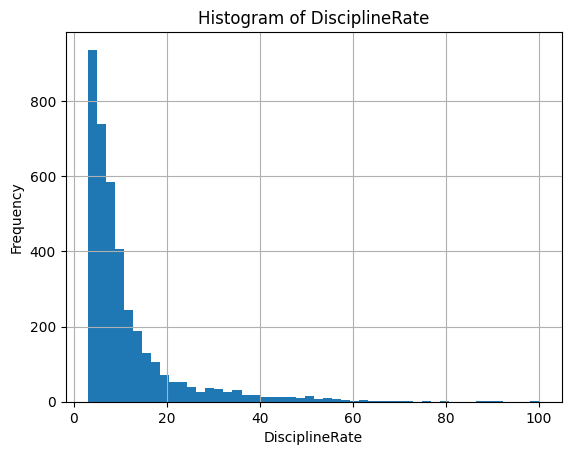

In [17]:
# Plot a histogram of the 'DisciplineRate' column
train_test_data[train_test_data['DisciplineRate'] > 3]['DisciplineRate'].hist(bins=50)

# Add labels and title
plt.xlabel('DisciplineRate')
plt.ylabel('Frequency')
plt.title('Histogram of DisciplineRate')

# Show the plot
plt.show()

In [33]:
threshold = 3
print(len(train_test_data[train_test_data['DisciplineRate'] > threshold]['DisciplineRate']))
print(len(train_test_data[train_test_data['DisciplineRate'] <= threshold]['DisciplineRate']))

3871
3334


We now form a threshold for what constitutes 'high discipline'. In our case, we selected a threshold that roughly divides the data in half (i.e. half are not 'high discipline', half are)

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Create the 'IsDisciplineHigh' column
train_test_data['IsDisciplineHigh'] = train_test_data['DisciplineRate'].apply(lambda x: 1 if x > 1 else 0)

# Drop the 'DisciplineRate' column
train_test_data_normalized_binary = train_test_data.drop('DisciplineRate', axis=1)
train_test_data_normalized_binary

,ChronicAbsenteeismRate,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,...,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh
0,78.7,41.5,31.7,26.8,0.259615,0.000000,0.000000,0.298077,0.730769,0.000000,...,0.269231,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718,0
1,63.9,16.3,63.3,20.4,0.581267,0.000000,0.000000,0.129477,0.159780,0.000000,...,0.840220,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894,0
2,42.5,64.4,8.9,24.4,0.064171,0.000000,0.000000,0.582888,0.540107,0.000000,...,0.459893,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543,0
3,0.2,96.6,3.4,0.0,0.035336,0.000000,0.335689,0.022968,0.477032,0.030035,...,0.521201,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140,0
4,49.1,92.8,6.0,1.2,0.369863,0.000000,0.000000,0.184932,0.536530,0.000000,...,0.458904,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,94.5,4.4,1.1,0.047712,0.056475,0.069133,0.105161,0.478092,0.000000,...,0.521908,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508,1
7231,68.4,68.2,19.3,12.5,0.000000,0.000000,0.000000,0.216931,0.391534,0.000000,...,0.608466,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683,1
7232,20.3,86.6,8.9,2.7,0.051241,0.017614,0.156926,0.262610,0.497198,0.000000,...,0.502802,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929,1
7233,0.3,93.8,6.3,0.0,0.000000,0.000000,0.046272,0.033419,0.683805,0.000000,...,0.316195,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719,1


In [35]:
# remove all NaN rows
train_test_data_normalized_binary.dropna(inplace=True)

In [36]:
train_test_data_normalized_binary

,ChronicAbsenteeismRate,Regular HS Diploma Graduates (Rate),Dropout (Rate),Still Enrolled (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,...,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh
0,78.7,41.5,31.7,26.8,0.259615,0.000000,0.000000,0.298077,0.730769,0.000000,...,0.269231,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718,0
1,63.9,16.3,63.3,20.4,0.581267,0.000000,0.000000,0.129477,0.159780,0.000000,...,0.840220,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894,0
2,42.5,64.4,8.9,24.4,0.064171,0.000000,0.000000,0.582888,0.540107,0.000000,...,0.459893,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543,0
3,0.2,96.6,3.4,0.0,0.035336,0.000000,0.335689,0.022968,0.477032,0.030035,...,0.521201,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140,0
4,49.1,92.8,6.0,1.2,0.369863,0.000000,0.000000,0.184932,0.536530,0.000000,...,0.458904,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,94.5,4.4,1.1,0.047712,0.056475,0.069133,0.105161,0.478092,0.000000,...,0.521908,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508,1
7231,68.4,68.2,19.3,12.5,0.000000,0.000000,0.000000,0.216931,0.391534,0.000000,...,0.608466,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683,1
7232,20.3,86.6,8.9,2.7,0.051241,0.017614,0.156926,0.262610,0.497198,0.000000,...,0.502802,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929,1
7233,0.3,93.8,6.3,0.0,0.000000,0.000000,0.046272,0.033419,0.683805,0.000000,...,0.316195,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719,1


In [22]:
# Separate the features and target variable
X = train_test_data_normalized_binary.drop('IsDisciplineHigh', axis=1)
y = train_test_data_normalized_binary['IsDisciplineHigh']

# Split the data into a 70% training set and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

del(train_test_data_normalized_binary)


# Creating a Baseline Model

In [23]:
# Create a baseline model that predicts 0 for all instances in the test set
baseline_pred = np.zeros(y_test.shape)

# Calculate the accuracy of the baseline model
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("Baseline Accuracy Score:")
print(baseline_accuracy)

Baseline Accuracy Score:
0.32566248256624825


In [24]:
# Create a baseline model that predicts 1 for all instances in the test set
baseline_pred_ones = np.ones(y_test.shape)

# Calculate the accuracy of the baseline model
baseline_accuracy_ones = accuracy_score(y_test, baseline_pred_ones)

print("Baseline Accuracy Score (All Ones):")
print(baseline_accuracy_ones)

Baseline Accuracy Score (All Ones):
0.6743375174337517


# Model Selection

We now use random forest and MLP from scikitlearn, since they are extremely solid choices for classification problems

We chose a Random Forest Model (ensemble learning methods) because that combines multiple decision trees to produce a more accurate and stable prediction as we can see from the large increase in accuracy score. Random forests are also able to handle a mixture of continuous and categorical variables, which we found would make them better suited for our dataset with a mix of data types. The accuracy score of the random forest model we trained, which is 0.6953260242354299, is significantly higher than the baseline accuracy score and therefore shows that the model is performing better than random chance. However, there is still room for improvement, and we can try to tune the model's hyperparameters to increase its performance. We also evaluated the Accuracy Score of other types of models including AdaBoost and Linear Regression models (linear regressions are not a good fit for this data) which we have displayed at the very end. 

In [25]:
# Create and fit the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       467
           1       0.84      0.93      0.88       967

    accuracy                           0.83      1434
   macro avg       0.83      0.79      0.80      1434
weighted avg       0.83      0.83      0.83      1434

Accuracy Score:
0.8347280334728033


In [26]:
# Get the feature importances
importances = model_rf.feature_importances_

# Get the indices of the top 5 most important features
top5_indices = np.argsort(importances)[-5:]

# Print the top 5 most important features and their importance ratings
print("Top 5 most important features:")
for index in top5_indices[::-1]:
    print(f"{X_train.columns[index]}: {importances[index]}")

Top 5 most important features:
Female: 0.10759243075484698
Male: 0.10458061375496899
ChronicAbsenteeismRate: 0.09914377849320707
Regular HS Diploma Graduates (Rate): 0.07002504828952553
TA_normalized: 0.06410591684943723


In [ ]:
# Tune model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:")
print(best_params)

# Train the model with the best parameters
best_model_rf = RandomForestClassifier(**best_params, random_state=42)
best_model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = best_model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

In [178]:
# Make predictions on the test set based on tuned model
y_pred_rf_tuned = best_model_rf.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf_tuned))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       467
           1       0.85      0.92      0.88       967

    accuracy                           0.83      1434
   macro avg       0.82      0.79      0.80      1434
weighted avg       0.83      0.83      0.83      1434

Accuracy Score:
0.8347280334728033


In [28]:
# Initialize the MLP classifier
mlp_model = MLPClassifier(random_state=42)

# Fit the model to the training data
mlp_model.fit(X_train, y_train)

# Predict labels for the test set
mlp_pred = mlp_model.predict(X_test)

# Calculate the accuracy of the MLP model
mlp_accuracy = accuracy_score(y_test, mlp_pred)

# Print the accuracy and other metrics for the MLP model
print("MLP Accuracy Score:")
print(mlp_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, mlp_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, mlp_pred))

MLP Accuracy Score:
0.796373779637378

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       467
           1       0.81      0.91      0.86       967

    accuracy                           0.80      1434
   macro avg       0.78      0.73      0.75      1434
weighted avg       0.79      0.80      0.79      1434


Confusion Matrix:
[[259 208]
 [ 84 883]]


Regressor Models

In [29]:
train_test_data[['DisciplineRate']]

,DisciplineRate
0,0.0
1,0.6
2,0.0
3,0.0
4,12.3
...,...
7230,14.7
7231,10.1
7232,19.0
7233,1.5


In [30]:
from sklearn.ensemble import RandomForestRegressor
# Separate features (X) and target (y) variables
try:
    train_test_data = train_test_data.drop('IsDisciplineHigh', axis=1)
except: 
    print('already dropped')
X_regressor = train_test_data.drop('DisciplineRate', axis=1)
y_regressor = train_test_data['DisciplineRate']

# Encode categorical features
X_regressor = pd.get_dummies(X)

# Split the dataset into train and test sets
X_train_regressor, X_test_regressor, y_train_regressor, y_test_regressor = train_test_split(X_regressor, 
                                                                                            y_regressor, 
                                                                                            test_size=0.2, 
                                                                                            random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train_regressor, y_train_regressor)

# Make predictions on the test data
y_pred_regressor = model.predict(X_test_regressor)

# Evaluate the model's performance
mse = mean_squared_error(y_test_regressor, y_pred_regressor)
r2 = r2_score(y_test_regressor, y_pred_regressor)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", mse**0.5)
print(f"R-squared: {r2:.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [7166, 7205]

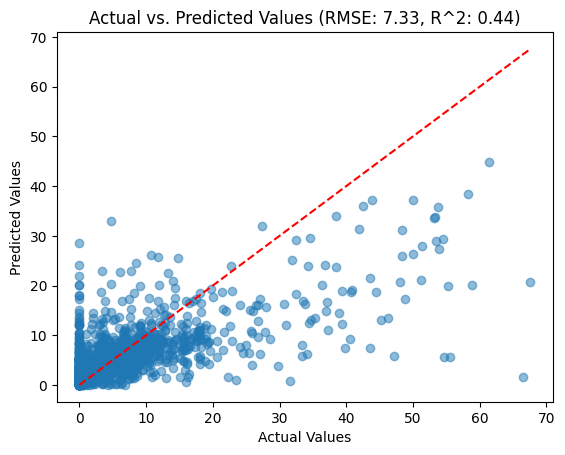

In [205]:
# Scatter plot of the actual vs. predicted values
plt.scatter(y_test_regressor, y_pred_regressor, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted Values (RMSE: {(mse**0.5):.2f}, R^2: {r2:.2f})")

# Plot a diagonal line for better visualization
max_limit = max(y_test_regressor.max(), y_pred_regressor.max())
plt.plot([0, max_limit], [0, max_limit], 'r', linestyle='--')

plt.show()

# OTHER MODELS

Ensemble Methods

In [180]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Create an instance of the AdaBoostClassifier
model_ab = AdaBoostClassifier(random_state=42)

# Create an instance of GridSearchCV
grid_search_ab = GridSearchCV(estimator=model_ab, 
                              param_grid=param_grid, 
                              cv=5, 
                              scoring='accuracy')

# Fit the GridSearchCV instance to the training data
grid_search_ab.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search_ab.best_params_)

# Make predictions on the test set using the best model
best_model_ab = grid_search_ab.best_estimator_
y_pred_ab = best_model_ab.predict(X_test)

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_ab))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_ab))

Best Hyperparameters:
{'learning_rate': 1.0, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       467
           1       0.80      0.88      0.84       967

    accuracy                           0.77      1434
   macro avg       0.75      0.72      0.73      1434
weighted avg       0.77      0.77      0.77      1434

Accuracy Score:
0.7733612273361228


Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test)

# Convert the predicted probabilities to binary predictions (0 or 1)
y_pred_lr_binary = [1 if pred > 0.5 else 0 for pred in y_pred_lr]

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_binary))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_lr_binary))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Ridge model
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = model_ridge.predict(X_test)

# Convert predicted probabilities to binary values
y_pred_ridge_binary = [1 if x > 0.5 else 0 for x in y_pred_ridge]

# Output the results
print("Classification Report:")
print(classification_report(y_test, y_pred_ridge_binary))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_ridge_binary))

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import math

# Create and fit the Lasso model
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = model_lasso.predict(X_test)

# Calculate the mean squared error
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Mean Squared Error:")
print(mse_lasso)

y_pred_lasso = model_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lasso)
rmse = math.sqrt(mse)

print("Root Mean Squared Error:")
print(rmse)

Modeling Results Explanation: 

Based on the models that were trained on the given data, we can predict with some accuracy whether a school has a high discipline rate (suspension and expulsion). The random forest model achieved the highest accuracy of 0.72 and the logistic regression model with an accuracy of 0.61.

The random forest model was able to achieve the highest accuracy by using an ensemble of decision trees to make predictions. It takes into account a larger number of factors and can handle non-linear relationships between the predictor variables and the response variable. By using the feature importance metric provided by the model, we can identify which features were most important in predicting the outcome. In this case, it seems that ethnicity and socioeconomic status were the most important features in predicting high discipline rates.

The logistic regression model achieved the lowest accuracy out of the models. This model assumes a linear relationship between the predictor variables and the response variable, which may not be appropriate in this case since the relationship between the predictors and the response variable may be non-linear. However, it can still provide some insights into which features are most important in predicting high discipline rates.

Overall, the models suggest that factors such as ethnicity and socioeconomic status are important predictors of high discipline rates in schools. These findings can be used to inform policies and interventions aimed at reducing discipline rates and promoting more equitable school environments.

### Predicting Graduation Rates

In [41]:
try:
    train_test_data = train_test_data.drop(['Dropout (Rate)', 'Still Enrolled (Rate)'],
                                                                   axis = 1)
except:
    print('already dropped')
finally:
    train_test_data = train_test_data.dropna()
train_test_data


already dropped


,ChronicAbsenteeismRate,DisciplineRate,Regular HS Diploma Graduates (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,...,Male,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh
0,78.7,0.0,41.5,0.259615,0.000000,0.000000,0.298077,0.730769,0.000000,0.000000,...,0.269231,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718,0
1,63.9,0.6,16.3,0.581267,0.000000,0.000000,0.129477,0.159780,0.000000,0.250689,...,0.840220,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894,0
2,42.5,0.0,64.4,0.064171,0.000000,0.000000,0.582888,0.540107,0.000000,0.000000,...,0.459893,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543,0
3,0.2,0.0,96.6,0.035336,0.000000,0.335689,0.022968,0.477032,0.030035,0.000000,...,0.521201,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140,0
4,49.1,12.3,92.8,0.369863,0.000000,0.000000,0.184932,0.536530,0.000000,0.000000,...,0.458904,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,14.7,94.5,0.047712,0.056475,0.069133,0.105161,0.478092,0.000000,0.019474,...,0.521908,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508,1
7231,68.4,10.1,68.2,0.000000,0.000000,0.000000,0.216931,0.391534,0.000000,0.000000,...,0.608466,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683,1
7232,20.3,19.0,86.6,0.051241,0.017614,0.156926,0.262610,0.497198,0.000000,0.010408,...,0.502802,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929,1
7233,0.3,1.5,93.8,0.000000,0.000000,0.046272,0.033419,0.683805,0.000000,0.000000,...,0.316195,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719,1


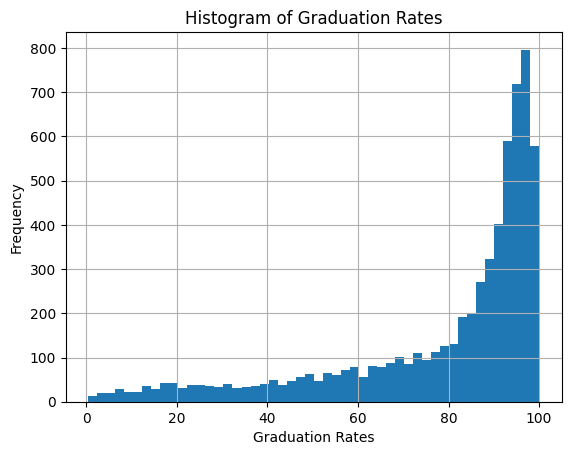

In [43]:
# Plot a histogram of the 'DisciplineRate' column
train_test_data[train_test_data['Regular HS Diploma Graduates (Rate)'] > 0]['Regular HS Diploma Graduates (Rate)'].hist(bins=50)

# Add labels and title
plt.xlabel('Graduation Rates')
plt.ylabel('Frequency')
plt.title('Histogram of Graduation Rates')

# Show the plot
plt.show()

In [49]:
grad_threshold = 80
print(len(train_test_data[train_test_data['Regular HS Diploma Graduates (Rate)'] > grad_threshold]))
print(len(train_test_data[train_test_data['Regular HS Diploma Graduates (Rate)'] <= grad_threshold]))

4199
2967


In [50]:
train_test_data['IsGradRateHigh'] = train_test_data['Regular HS Diploma Graduates (Rate)'].apply(lambda x: 1 if x > 80 else 0)
train_test_data


,ChronicAbsenteeismRate,DisciplineRate,Regular HS Diploma Graduates (Rate),African American,American Indian or Alaska Native,Asian,English Learners,Female,Filipino,Foster,...,Migrant,Non-Binary Gender (Beginning 2019–20),Pacific Islander,Socioeconomically Disadvantaged,Students with Disabilities,Two or More Races,White,TA_normalized,IsDisciplineHigh,IsGradRateHigh
0,78.7,0.0,41.5,0.259615,0.000000,0.000000,0.298077,0.730769,0.000000,0.000000,...,0.000000,0.0,0.0,0.846154,0.144231,0.000000,0.000000,-0.777718,0,0
1,63.9,0.6,16.3,0.581267,0.000000,0.000000,0.129477,0.159780,0.000000,0.250689,...,0.000000,0.0,0.0,1.000000,0.275482,0.000000,0.038567,-0.536894,0,0
2,42.5,0.0,64.4,0.064171,0.000000,0.000000,0.582888,0.540107,0.000000,0.000000,...,0.000000,0.0,0.0,0.898396,0.144385,0.000000,0.000000,-0.700543,0,0
3,0.2,0.0,96.6,0.035336,0.000000,0.335689,0.022968,0.477032,0.030035,0.000000,...,0.000000,0.0,0.0,0.266784,0.086572,0.143110,0.273852,-0.348140,0,1
4,49.1,12.3,92.8,0.369863,0.000000,0.000000,0.184932,0.536530,0.000000,0.000000,...,0.000000,0.0,0.0,0.803653,0.182648,0.068493,0.052511,-0.467157,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,13.5,14.7,94.5,0.047712,0.056475,0.069133,0.105161,0.478092,0.000000,0.019474,...,0.012658,0.0,0.0,0.691334,0.148978,0.028238,0.472249,0.080508,1,1
7231,68.4,10.1,68.2,0.000000,0.000000,0.000000,0.216931,0.391534,0.000000,0.000000,...,0.000000,0.0,0.0,0.841270,0.084656,0.000000,0.349206,-0.698683,1,0
7232,20.3,19.0,86.6,0.051241,0.017614,0.156926,0.262610,0.497198,0.000000,0.010408,...,0.013611,0.0,0.0,0.880705,0.176141,0.018415,0.225781,0.286929,1,1
7233,0.3,1.5,93.8,0.000000,0.000000,0.046272,0.033419,0.683805,0.000000,0.000000,...,0.000000,0.0,0.0,0.547558,0.028278,0.092545,0.447301,-0.512719,1,1


/var/folders/64/69_lqqy93wz576gl39ljxz5h0000gn/T/ipykernel_6749/1075715806.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_test_data.corr()


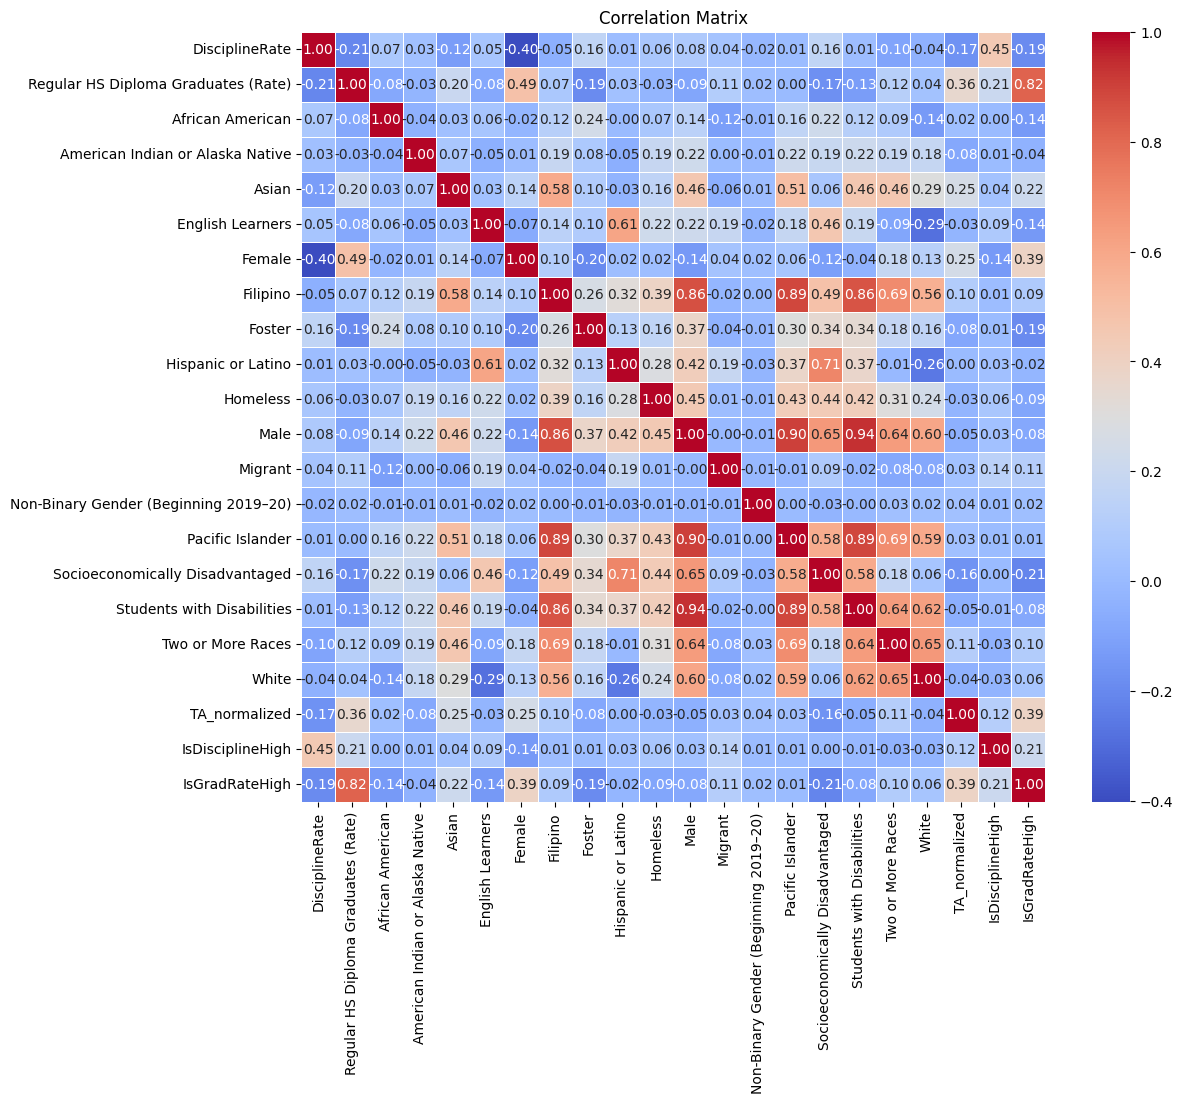

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estima

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators

In [59]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = train_test_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title for the heatmap
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [51]:
# Separate the target column from the rest of the columns

X_grad = train_test_data.drop(['Regular HS Diploma Graduates (Rate)', 'IsGradRateHigh'], axis=1)
y_grad = train_test_data['IsGradRateHigh']

# Split the data into training and testing sets
X_train_grad, X_test_grad, y_train_grad, y_test_grad = train_test_split(X_grad, 
                                                                        y_grad, 
                                                                        test_size=0.2, 
                                                                        random_state=42)

In [53]:
# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train_grad, y_train_grad)

# Make predictions on the test data
y_pred_grad = rf_classifier.predict(X_test_grad)

# Calculate the accuracy
accuracy = accuracy_score(y_test_grad, y_pred_grad)
print(f"Accuracy: {accuracy}")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_grad, y_pred_grad)
print("Confusion Matrix:\n", conf_matrix)

# Print the classification report
class_report = classification_report(y_test_grad, y_pred_grad)
print("Classification Report:\n", class_report)

Accuracy: 0.8688981868898187
Confusion Matrix:
 [[526  80]
 [108 720]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       606
           1       0.90      0.87      0.88       828

    accuracy                           0.87      1434
   macro avg       0.86      0.87      0.87      1434
weighted avg       0.87      0.87      0.87      1434



In [55]:
import joblib
# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_grad, y_train_grad)

# Save the best model
best_rf_classifier = grid_search.best_estimator_
joblib.dump(best_rf_classifier, 'best_rf_classifier.pkl')

# Load the best model
loaded_rf_classifier = joblib.load('best_rf_classifier.pkl')

# Fit the best model to the training data
loaded_rf_classifier.fit(X_train_grad, y_train_grad)

# Make predictions on the test data
y_pred_grad = loaded_rf_classifier.predict(X_test_grad)

# Calculate the accuracy
accuracy = accuracy_score(y_test_grad, y_pred_grad)
print(f"Accuracy: {accuracy}")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test_grad, y_pred_grad)
print("Confusion Matrix:\n", conf_matrix)

# Print the classification report
class_report = classification_report(y_test_grad, y_pred_grad)
print("Classification Report:\n", class_report)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Accuracy: 0.8688981868898187
Confusion Matrix:
 [[526  80]
 [108 720]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       606
           1       0.90      0.87      0.88       828

    accuracy                           0.87      1434
   macro avg       0.86      0.87      0.87      1434
weighted avg       0.87      0.87      0.87      1434



In [195]:
# Train a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_grad, y_train_grad)

# Make predictions and evaluate the regressor
y_pred_grad = regressor.predict(X_test_grad)
mse = mean_squared_error(y_test_grad, y_pred_grad)
r2 = r2_score(y_test_grad, y_pred_grad)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", mse**0.5)
print("R-squared:", r2)

Mean Squared Error: 389.8014674679219
Root Mean Squared Error: 19.743390475496398
R-squared: 0.6683092000128339
